In [1]:
import pwd
from IPython import get_ipython

get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')

/tmp/ipykernel_3268/2117665699.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('load_ext autoreload')
/tmp/ipykernel_3268/2117665699.py:5: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('autoreload 2')


In [2]:
import functools
from typing import Any, Callable, Sequence, Optional

import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from flax.training import train_state
import jax
from jax import lax, random, numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax

from dbopt.Datasets import Spiral

In [3]:
seed = 23
key = random.PRNGKey(seed)

In [4]:
key, ds_key = random.split(key)
spiral = Spiral(100, ds_key)
dataset = spiral.get_dataset()


def make_batches(key, dataset, batch_size=64):
    """This method returns a list containing batches sampled randomly from the
    dataset, with the indicated batch size (except for the last batch, which
    might be smaller"""

    
    n_points = dataset.shape[0]
    remainder = n_points % batch_size
    num_full_batches = (n_points - remainder)/batch_size
    permuted_dataset = random.permutation(key, dataset)
    batches_list = []
    for batch in range(int(num_full_batches)):
        batches_list.append(permuted_dataset[batch:batch+batch_size, :])
    batches_list.append(permuted_dataset[-remainder-1:-1, :])
    return batches_list


In [5]:
class FCNN(nn.Module):
    num_neurons_per_layer: Sequence[int]  # data field (nn.Module is Python's dataclass)

    def setup(self):  # because dataclass is implicitly using the  __init__ function... :')
        self.layers = [nn.Dense(n) for n in self.num_neurons_per_layer]

    def __call__(self, x):
        activation = x
        for i, layer in enumerate(self.layers):
            activation = layer(activation)
            if i != len(self.layers) - 1:
                activation = nn.relu(activation)
        return jnp.exp(nn.log_softmax(activation))

model = FCNN(num_neurons_per_layer=[10, 10, 10, 10, 10, 2])
key, init_x_key = random.split(key)
x_init = random.uniform(init_x_key, (2,))
key, init_key = random.split(key)
params = model.init(init_key, x_init)


In [6]:
def make_loss_fn(model, data, labels):
    def loss_fn(params):
        preds = model.apply(params, data)
        one_hot_gt_labels = jax.nn.one_hot(labels, num_classes=2)
        loss = -jnp.mean(jnp.sum(one_hot_gt_labels * jnp.log(preds), axis=-1))
        return loss   
    return loss_fn

In [7]:
opt = optax.adam(learning_rate=0.01)
opt_state = opt.init(params)

In [8]:
epochs = 100

for epoch in range(epochs):
    key, batch_key = random.split(key)
    batches = make_batches(batch_key, dataset)
    epoch_loss = jnp.empty((len(batches),))
    for batch_nb, batch in enumerate(batches):
        batch_data = batch[:, 1:]
        batch_labels = jnp.squeeze(batch[:, :1], axis=1)
        loss = make_loss_fn(model, batch_data, batch_labels)
        loss, grads = jax.value_and_grad(loss)(params)
        epoch_loss = epoch_loss.at[batch_nb].set(loss)
        updates, opt_state = opt.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        
    if epoch % 5 == 0:
        #print(jnp.mean(epoch_loss))
        print(f'epoch {epoch}, loss = {loss}')
    

/home/ghenassia_n/dbopt-py39/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


epoch 0, loss = 0.5326917767524719
epoch 5, loss = 0.6580117344856262
epoch 10, loss = 0.38121840357780457
epoch 15, loss = 0.7451888918876648
epoch 20, loss = 0.6234604120254517
epoch 25, loss = 0.6062660217285156
epoch 30, loss = 0.473694384098053
epoch 35, loss = 0.35707566142082214
epoch 40, loss = 0.25556501746177673
epoch 45, loss = 0.3169868588447571
epoch 50, loss = 0.21422818303108215
epoch 55, loss = 0.0821853056550026
epoch 60, loss = 0.34703946113586426
epoch 65, loss = 0.09248123317956924
epoch 70, loss = 0.11464685946702957
epoch 75, loss = 0.0031499750912189484
epoch 80, loss = 0.021170994266867638
epoch 85, loss = 0.008036528714001179
epoch 90, loss = 0.008497899398207664
epoch 95, loss = 0.021563667804002762


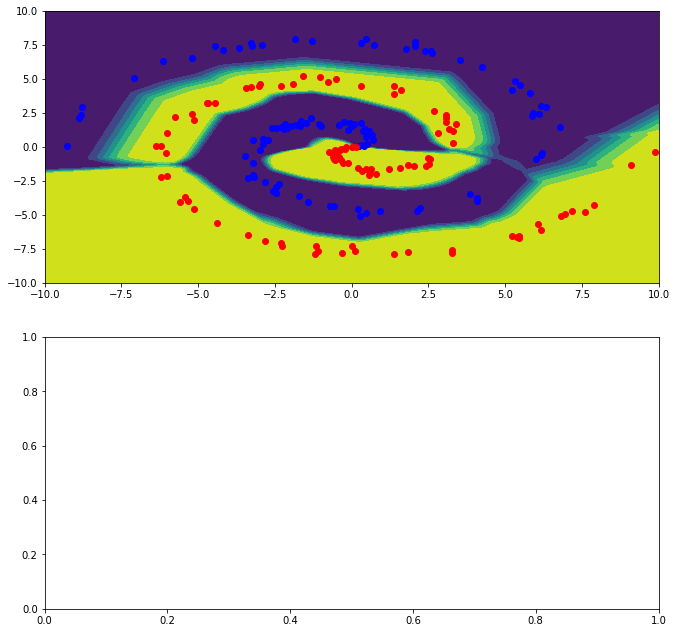

In [9]:
def plot_decision_boundary(ax, x_min=-10., x_max=10., y_min=-10., y_max=10.):
    """This function allows to plot the network's decision boundary on a given figure.

    Args:
    ax (matplotlib.axes.Axes): the pyplot figure on which the dataset is plotted.
    x_min (float, optional): lower bound of the x axis of the plot. Defaults to -10..
    x_max (float, optional): high bound of the x axis of the plot. Defaults to 10..
    y_min (float, optional): lower bound of the y axis of the plot. Defaults to -10..
    y_max (float, optional): high bound of the y axis of the plot. Defaults to 10..
    """
    x = jnp.linspace(x_min, x_max, 220)
    y = jnp.linspace(y_min, y_max, 220)
    grid_x = jnp.meshgrid(x, y)[0].reshape(-1, 1)
    grid_y = jnp.meshgrid(x, y)[1].reshape(-1, 1)
    grid = jnp.concatenate([grid_x, grid_y], axis=1)

    grid = jnp.expand_dims(grid, axis=1)
    out = model.apply(params, grid)
    out = np.squeeze(out, axis=1)[: , 1].reshape(len(x), -1)

    ax.contourf(jnp.meshgrid(x, y)[0], jnp.meshgrid(x, y)[1], out)

fig, (ax1, ax2) = plt.subplots(2, figsize=(11, 11))
spiral.plot(ax1)
plot_decision_boundary(ax1)



In [28]:
from dbopt.FCNN import FCNN

network = FCNN(num_neurons_per_layer=[10, 10, 10, 10, 10, 2])
key, init_x_key = random.split(key)
x_init = random.uniform(init_x_key, (2,))
key, init_key = random.split(key)
params = network.init(init_key, x_init)

[autoreload of dbopt.FCNN failed: Traceback (most recent call last):
  File "/home/ghenassia_n/dbopt-py39/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/ghenassia_n/dbopt-py39/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/home/ghenassia_n/dbopt-py39/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/home/ghenassia_n/dbopt-py39/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/home/ghenassia_n/dbopt-py39/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 303, in update_instances
    ref.__class__ = new
  File "/home/ghenassia_n/dbopt-py39/lib/python3.9/site-packages/flax/linen/module.py", line 700, in __setattr__
    raise errors.SetAttributeFrozenM

started training


/home/ghenassia_n/dbopt-py39/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


epoch 0, loss = 0.7118601202964783
epoch 5, loss = 0.7965847253799438
epoch 10, loss = 1.009459137916565
epoch 15, loss = 0.6089254021644592
epoch 20, loss = 0.564333438873291
epoch 25, loss = 0.5325838923454285
epoch 30, loss = 0.7386982440948486
epoch 35, loss = 0.3349303901195526
epoch 40, loss = 0.8130836486816406
epoch 45, loss = 0.28197479248046875
epoch 50, loss = 0.3212592303752899
epoch 55, loss = 0.06829985976219177
epoch 60, loss = 0.37172409892082214
epoch 65, loss = 0.1868324726819992
epoch 70, loss = 0.04674079269170761
epoch 75, loss = 0.11417418718338013
epoch 80, loss = 0.0016300349961966276
epoch 85, loss = 0.3853902816772461
epoch 90, loss = 0.16264887154102325
epoch 95, loss = 0.08511468768119812
epoch 100, loss = 0.10806933790445328
epoch 105, loss = 0.06995593756437302
epoch 110, loss = 0.008051091805100441
epoch 115, loss = 0.0010824569035321474
epoch 120, loss = 0.07997531443834305
epoch 125, loss = 0.00028780443244613707
epoch 130, loss = 0.19467036426067352
ep

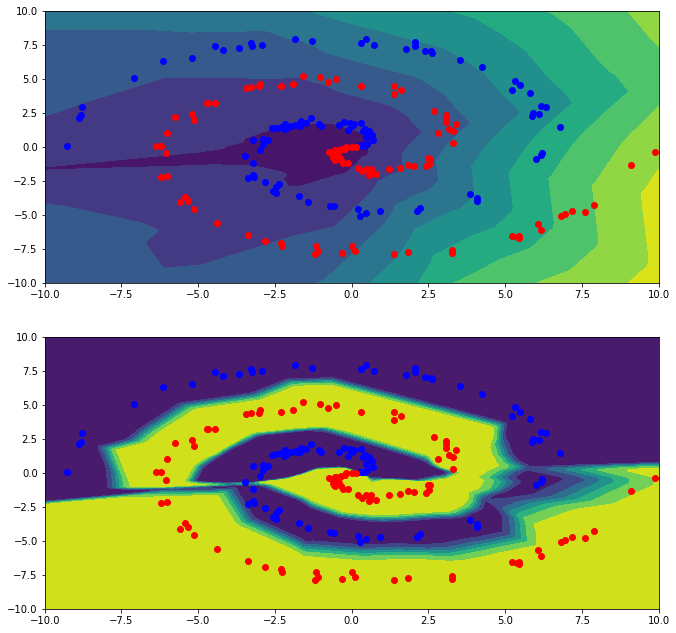

In [29]:
#print(jax.tree_map(lambda x: x.shape, params))
fig, (ax1, ax2) = plt.subplots(2, figsize=(11, 11))
spiral.plot(ax1)
network.plot_decision_boundary(params, ax1)
key, train_key = random.split(key)
params = network.train(train_key, params, dataset, 150)
spiral.plot(ax2)
network.plot_decision_boundary(params, ax2)

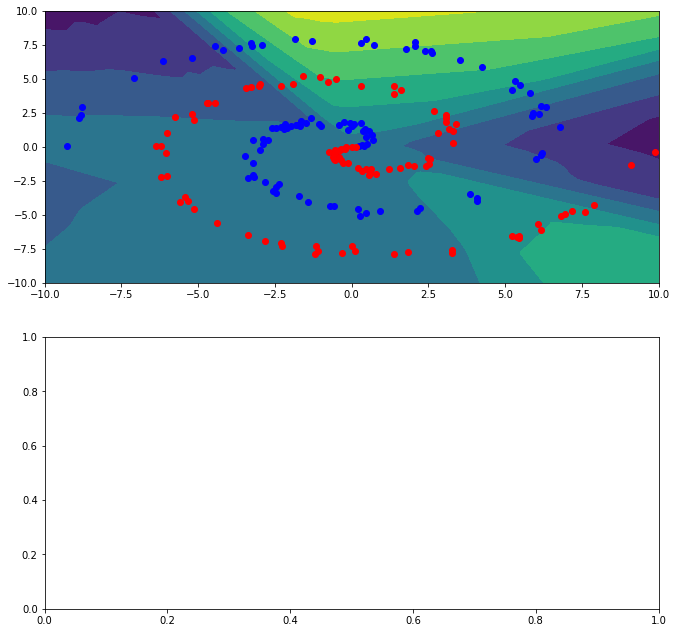

In [21]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(11, 11))
spiral.plot(ax1)
network.plot_decision_boundary(params, ax1)